# 3 - Level Flying Cap Converter

<a href="https://colab.research.google.com/github/idea-fasoc/OpenFASOC/blob/main/docs/source/notebooks/temp_sense_genCollab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
AC3E Microelectronics Team, November 2022
SPDX-License-Identifier: Apache-2.0
```


|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
| Jorge Marín <br /> Email ID: jorge.marinn@usm.cl|AC3E (Chile)| No |No|
| Christian Rojas <br /> Email ID: c.a.rojas@ieee.org|AC3E, Universidad Técnica Federico Santa María (Chile)| Yes |No|
| Joel Gak |Universidad Católica de Uruguay (Uruguay)| No |No|
| Nicolás |Universidad Católica de Uruguay (Uruguay)| No |No|
| Alfonso Cortés |AC3E, Universidad Técnica Federico Santa María (Chile)| Yes |No|
| Aquiles Viza |AC3E, Universidad Técnica Federico Santa María (Chile)| No |No|
| Kevin Pizarro |Universidad Técnica Federico Santa María (Chile)| No |No|
| Sebastián Neira |AC3E, Universidad Técnica Federico Santa María (Chile)| No |No|
| Vicente Osorio |Universidad Técnica Federico Santa María (Chile)| No |No|
| Tomás Velásquez|Universidad Técnica Federico Santa María (Chile)| No |No|
| Max Vega |Universidad Técnica Federico Santa María (Chile)| No |No|
| Julio Contreras |Universidad Técnica Federico Santa María (Chile)| No |No|
| Diego Almonacid |Universidad Técnica Federico Santa María (Chile)| No |No|
| Carolina Beckmann |Universidad Técnica Federico Santa María (Chile)| Yes |No|
| Pablo Vera |Universidad Técnica Federico Santa María (Chile)| No |No|


## Introduction

Our project focuses on designing and implementing a DC-DC buck converter demonstrator based on the three-level flying capacitor converter (3L-FCC) architecture, a simple but versatile type of FCML converter, using the Skywater 130nm CMOS technology (SKY130). Since power conversion at low voltage levels has already been demonstrated in the SKY130 technology in previous work [7], we set our focus on the buck conversion block between the high voltages in solar panels (20V) and the intermediate unregulated voltages in the DC bus (12V) for photo-voltaic input channel in CubeSat applications. In our proposed architecture and topologies, depicted in Fig. 2, the power circuits are fully integrated on-chip, including the power MOSFETs (PM), the flying capacitor (FC) and the gate drivers (GD). The switching control will be delivered externally or using the integrated RISC-V module, to allow for experiments with different modulation and control schemes. 

**Aún por cambiar**>>

**_Index Terms:_** Circuit generator, leakage-based temperature dependency, open source, synthesizable design, temperature sensor.

Citation: Q. Zhang et al., "An Open-Source and Autonomous Temperature Sensor Generator Verified With 64 Instances in SkyWater 130 nm for Comprehensive Design Space Exploration," in IEEE Solid-State Circuits Letters, vol. 5, pp. 174-177, 2022, doi: 10.1109/LSSC.2022.3188925.


[^1]: This notebook is targeted at users of all professional backgrounds aiming to learn how to *code* their chips. The goal is to go through all the steps of generating the temperature sensor and an overview of the simulation results. 

## About the converter and level shifters

In general, this converter allows flexibility for control and gives the possibility of achieving better signal quality, but also the option of using it as a buck or boost converter. In this case, it is being used as a buck converter.
This converter works on 4 states, described in figure 1, as seen below. 

</br>

<div>
<img src="/tree/Images/3LFC_states.png" width="350"/>
</div>

</br> 

<center>Figure 1: 3-LFCC States</center>

</br> 

Yet for achieving the logic levels necessary for other applications that are normally higher than the ones at the chip, so it is necessary to use level shifters. The level shifters used in this project are the ones depicted in figure 2.


</br>

<div>
<img src="/tree/Images/levelshift.jpeg" width="350"/>
</div>

</br> 

<center>Figure 2: Level Shifters schematic</center>

</br> 



## Install tools and dependencies

In [ ]:
# install all tools and dependencies
import os
import pathlib
import sys

!pip install matplotlib pandas pyinstaller
!apt-get install -y ruby-full time build-essential
!apt install -f libqt4-designer libqt4-xml libqt4-sql libqt4-network libqtcore4 libqtgui4
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        open_pdks.sky130a \
                        magic \
                        netgen \
                        openroad \
                        yosys
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel conda-forge \
                        tcllib gdstk pyyaml click svgutils ngspice
#!bin/micromamba install --yes --prefix $CONDA_PREFIX \
#                        --channel conda-forge \
#                        klayout

!wget https://www.klayout.org/downloads/Ubuntu-18/klayout_0.27.11-1_amd64.deb
!dpkg -i klayout_0.27.11-1_amd64.deb

# clone OpenFASOC repo
!git clone https://github.com/idea-fasoc/OpenFASOC
# setup env
OPENFASOC_ROOT=str(pathlib.Path('OpenFASOC').resolve())
TEMP_SENSE_ROOT=OPENFASOC_ROOT+"/openfasoc/generators/temp-sense-gen/"
PATH=os.environ['PATH']
%env PDK_ROOT={CONDA_PREFIX}/share/pdk
%env OPENFASOC_ROOT={OPENFASOC_ROOT}
%env PATH={PATH}:{OPENFASOC_ROOT}:{OPENFASOC_ROOT}/openfasoc/generators/temp-sense-gen/tools
# pip3 packages
!apt install python3-pip
!pip3 install matplotlib pandas pyinstaller ipykernel

## Simulation

The switch design is initially based on the 10V thick oxide NMOS and PMOS power devices implemented in the Open PMIC project. The device sizes are shown below.

**ver si esto va**


### PMOS R_ON calculation

Below, there will be two sections that have parameters that can be tweaked for the case to be analyzed by the user, both being the schematic and the python file used to manipulate the data.

#### Generating the data
This cell allows to run the .sch file for calculating the PMOS Ron characteristic through a SPICE simulation

In [ ]:
!xschem PMOS_allfingers_RONcalc_v2p2_20220626.sch -n -S

#### Running the plot 

This cell allows to run a .py file to plot the R_ON characteristic for a PMOS for different VGS values by using the data generated by the .sch file.

The R_ON value for the typical PMOS switch device at 70°C , without parasitics, for IDS = 300mA, **is roughly 0.28Ohm** (see plot below).

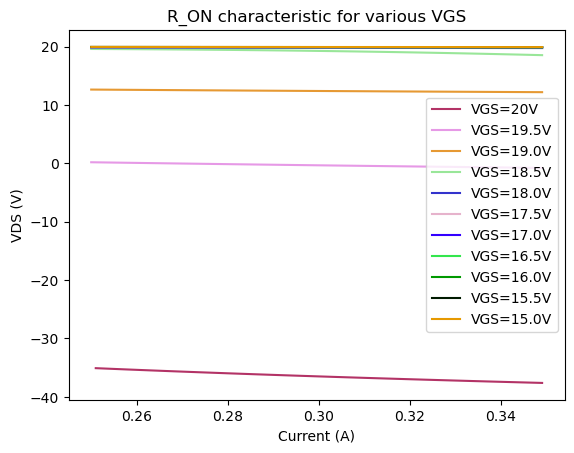

In [7]:
import pandas as pd
import numpy as np
import random as rand
from matplotlib import pyplot as plt

colors=(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1)
df=pd.read_fwf('PMOS_R_on_calc.txt')
df.to_csv('PMOS_R_on_calc.csv', index=False)
data = pd.read_csv('PMOS_R_on_calc.csv').values

## If you want to change the start, stop and step in the .sch file, you may change this parameters
## here, named start, stop and step.
start=20
stop=15
step=0.5
VGS=[]
while start>=stop:
    VGS.append('VGS='+str(start)+'V')
    start-=step

## If you want to change the current sweep step  in the for more data, you may change this parameter
## here, named current_sweep_step.
current_sweep_step=100
under=0
top=current_sweep_step-1   

row1=0
row2=0
i=0

flag=True
for volt in VGS:
    
    row1=under
    row2=top
    if flag:
        under+=current_sweep_step
        flag=False
    else:
        under+=current_sweep_step+1
    top+=current_sweep_step+1
    if volt==VGS[0]:
        current = data[0:row2,0]
        voltage = data[0:row2,1]
    else:
        current = data[row1:row2,0]
        voltage = data[row1:row2,1]
    plt.plot(current,voltage, color=(rand.choice(colors),rand.choice(colors),rand.choice(colors)),label=volt)
    
plt.xlabel('Current (A)')
plt.ylabel('VDS (V)')
plt.title('R_ON characteristic for various VGS')
plt.legend()
plt.show()  

### NMOS Ron calculation

Below, there will be two sections that have parameters that can be tweaked for the case to be analyzed by the user, both being the schematic and the python file used to manipulate the data.

#### Opening and simulating the schematic
This cell below allows to run the .sch file for calculating the NMOS R_ON characteristic through a SPICE simulation

In [ ]:
!xschem NMOS_allfingers_RONcalc_v2p2_20220626.sch -n -S

#### Running the plot

This cell allows to run a .py file to plot the R_ON characteristic for a NMOS for different VGS values by using the data generated by the .sch file

The R_ON value for the typical NMOS switch device at 70°C , without parasitics, for IDS = 300mA, **is roughly 0.17Ohm** (see plot below).

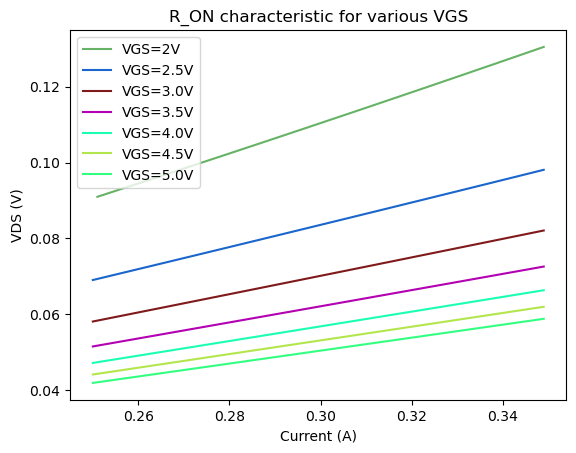

In [8]:
import pandas as pd
import numpy as np
import random as rand
from matplotlib import pyplot as plt

colors=(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1)
df=pd.read_fwf('NMOS_R_on_calc.txt')
df.to_csv('NMOS_R_on_calc.csv', index=False)
data = pd.read_csv('NMOS_R_on_calc.csv').values

## If you want to change the start, stop and step in the .sch file, you may change this parameters
## here, named start, stop and step.
start=2
stop=5
step=0.5
VGS=[]
while start<=stop:
    VGS.append('VGS='+str(start)+'V')
    start+=step

## If you want to change the current sweep step  in the for more data, you may change this parameter
## here, named current_sweep_step.
current_sweep_step=100
under=0
top=current_sweep_step-1   

row1=0
row2=0
i=0

flag=True
for volt in VGS:
    
    row1=under
    row2=top
    if flag:
        under+=current_sweep_step
        flag=False
    else:
        under+=current_sweep_step+1
    top+=current_sweep_step+1
    if volt==VGS[0]:
        current = data[0:row2,0]
        voltage = data[0:row2,1]
    else:
        current = data[row1:row2,0]
        voltage = data[row1:row2,1]
    plt.plot(current,voltage, color=(rand.choice(colors),rand.choice(colors),rand.choice(colors)),label=volt)
    
plt.xlabel('Current (A)')
plt.ylabel('VDS (V)')
plt.title('R_ON characteristic for various VGS')
plt.legend()
plt.show()  

### Efficiency

Below, there will be two sections that have parameters that can be tweaked for the case to be analyzed by the user, both being the schematic and the python file used to manipulate the data.


#### Opening and simulating the schematic

This cell allows to run the .sch file for calculating the efficiency of a core from the converter through a SPICE simulation.

In [ ]:
!xschem core_testbench_wfilter.sch -n -S

#### Running the plot

This cell allows to run a .py file to plot the converter efficiency, with and without level shifters involved, for different load values by using the data generated by the .sch file

The R_ON value for the typical NMOS switch device at 70°C , without parasitics, for IDS = 300mA, **is roughly 0.17Ohm** (see plot below).

Load: 50 ohms
Peak length: 23
Efficiency: 86.97203714402934 %
Efficiency (considering level shifter): 82.2455254221848 %
Load: 45 ohms
Peak length: 21
Efficiency: 87.59617740255412 %
Efficiency (considering level shifter): 83.1486848316201 %
Load: 40 ohms
Peak length: 21
Efficiency: 87.91237613782668 %
Efficiency (considering level shifter): 83.8956320262659 %
Load: 35 ohms
Peak length: 22
Efficiency: 88.75036300102734 %
Efficiency (considering level shifter): 83.44140797547146 %
Load: 30 ohms
Peak length: 22
Efficiency: 89.52566569897684 %
Efficiency (considering level shifter): 84.44967251634998 %
Load: 25 ohms
Peak length: 23
Efficiency: 89.82483646550783 %
Efficiency (considering level shifter): 86.61060670142469 %
Load: 20 ohms
Peak length: 23
Efficiency: 90.61621334976422 %
Efficiency (considering level shifter): 87.87913625258177 %
Load: 15 ohms
Peak length: 22
Efficiency: 91.31973346773229 %
Efficiency (considering level shifter): 88.99721335510432 %
Load: 10 ohms
Peak length: 

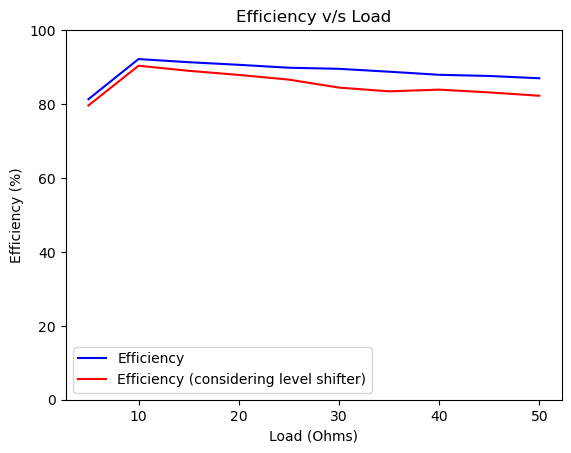

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

df=pd.read_fwf('3LFCC_core_wfilter_vicente.txt')
df.to_csv('3LFCC_core_wfilter_vicente.csv', index=False)
data = pd.read_csv('3LFCC_core_wfilter_vicente.csv').values



start=50
stop=5
step=5
r=[]
while start>=stop:
    r.append(start)
    start-=step
i_cut = 2000
i=0
pk_init = 10
eff_arr=[]
eff_ls_arr=[]


for res in r:
    flag=True
    for number in data:
        if flag:
            row1=i+i_cut
            flag=False
        if round(number[0],5)==0.00003:
            row2=i
            i+=1
            break
        i+=1
    print('Load:',res,'ohms')
    y_out = data[row1:row2,1]
    data_iout = data[row1:row2,7]
    y_in = (-1)*data[row1:row2,3]
    y_in_LS = (-1)*data[row1:row2,5]
    peaks , _ = find_peaks(y_in, height=0.7)
    pk_len = len(peaks)
    print('Peak length:',pk_len)
    vout = np.mean(y_out[peaks[pk_init]:peaks[pk_len-1]])
    iin = np.mean(y_in[peaks[pk_init]:peaks[pk_len-1]])
    ils = np.mean(y_in_LS[peaks[pk_init]:peaks[pk_len-1]])
    iout = np.mean(data_iout[peaks[pk_init]:peaks[pk_len-1]])
    pout = vout*iout
    pin = 5*iin
    eff_ls = (pout/(5*(iin+ils)))*(100)
    eff = (pout/pin )*(100)
    eff_arr.append(eff)
    eff_ls_arr.append(eff_ls)
    print('Efficiency:',eff,'%')
    print('Efficiency (considering level shifter):',eff_ls,'%')



plt.plot(r,eff_arr,color='b',label='Efficiency')
plt.plot(r,eff_ls_arr,color='r',label='Efficiency (considering level shifter)')
plt.xlabel('Load (Ohms)')
plt.ylabel('Efficiency (%)')
plt.title('Efficiency v/s Load')
plt.legend()
plt.ylim([0,100])
plt.show()

### Understanding User Input
The generator must first parse the user’s requirements into a high-level circuit description or verilog. Note that verilog is a circuit description type that uses theoretical constructs (like mathematical operators, if-else blocks, always @ blocks,... etc) to concisely describe circuits. User input parsing is implemented by reading from a JSON spec file directly in the temp-sense-gen repository. The JSON allows for specifying power, area, maximum error (temperature result accuracy), an optimization option (to choose which option to prioritize), and an operating temperature range (minimum and maximum operating temperature values). The operating temperature range and optimization must be specified, but other items can be left blank. The example we are using here runs the sky130 node, and we already have a silicon model file for this node. The generator uses this model file to automatically determine the number of headers and inverters, among other necessary modifications that can be made to meet spec. The generator references the model file in an iterative process until either meeting spec or failing. A verilog description is then produced by substituting specifics into several template verilog files.

You can see this solve and verilog generation by running the code below and exploring the temp-sense-gen/src folder in your python virtual environment:


In [ ]:
!cd OpenFASOC/openfasoc/generators/temp-sense-gen && make sky130hd_temp_verilog

### Logic Synthesis
At this phase, the implementation of fundamental components — such as transistors and resistors — is not considered. Logic synthesis takes the verilog description from the previous step and outputs a more detailed netlist by parsing theoretical verilog constructs like always, case, if-else, operator, etc… blocks. Note that a netlist is just a list of pins and component connections. Additionally the entire description is consolidated into one file (not considering the node specific library files we will need later) which means that the low and high voltage components are correctly connected. Specifics such as the shapes, placement, length, size of wires and components, along with power connections are still not considered. 

You can see the synthesis step by running the code below and viewing the temp-sense-gen/flow/results/sky130hd/tempsense/1_synth.v file in your python virtual environment:

In [ ]:
!cd OpenFASOC/openfasoc/generators/temp-sense-gen/flow && make synth

### Automatic Place and Route
Now that we have a description of our circuit which includes specific connections and components to use, it is possible to consider drawing the wires, placing the components, and choosing materials. Below is a step-by-step visual breakdown of the openroad APR.

#### Floorplan
First, an outline of the circuit is created encompassing the area that the circuit will occupy and including all the input and output pins for the top level circuit. Inside the temperature sensor, power rails, tap, and decap cells are placed. The tap and decap cells serve to address manufacturing and real-world circuit performance concerns. Within the box, a grid is formed with rows of fixed height.

Run floorplan and render a polygon graphic for this stage by executing the code below:

In [ ]:
!cd OpenFASOC/openfasoc/generators/temp-sense-gen/flow && make floorplan

In [ ]:
import gdstk
import os
import IPython.display
import svgutils.transform as sg
# work dir setup
!cp OpenFASOC/openfasoc/generators/temp-sense-gen/flow/results/sky130hd/tempsense/2_floorplan.odb OpenFASOC/docs/source/notebooks/aux_files
os.environ['from_oprd_'] = '2_floorplan.odb'
os.environ['to_oprd_'] = 'out2.def'
# convert odb to def
!cd OpenFASOC/docs/source/notebooks/aux_files && openroad -no_init -exit dbtodef.tcl
# convert def to gds
!cd OpenFASOC/docs/source/notebooks/aux_files && klayout -zz -rd design_name=tempsenseInst_error \
	        -rd in_def="out2.def" \
	        -rd in_gds="HEADER.gds SLC.gds sky130_fd_sc_hd.gds" \
	        -rd config_file="fill.json" \
	        -rd out_gds="out2.gds" \
	        -rd tech_file="klayout.lyt" \
	        -rm def2gds.py
!cp OpenFASOC/docs/source/notebooks/aux_files/out2.gds /content
flrpln = gdstk.read_gds("out2.gds".format(TEMP_SENSE_ROOT))
flrpln_top_cell = flrpln.top_level()
flrpln_top_cell[0].write_svg('out2.svg')
fig = sg.fromfile('out2.svg')
fig.set_size(('700','700'))
fig.save('out2.svg')
IPython.display.SVG('out2.svg')

####Place
Within the rows (visualized in the run above) the standard cells are placed. Cells are building block circuits that, when combined, implement the bulk of temperature sensor functionality. These standard components include: inverters or other logic gates, headers (used to convert from high to low voltage), SLC (used to convert from low to high voltage), etc. 

Run place and render a polygon graphic for this stage by executing the code below:

In [ ]:
!cd OpenFASOC/openfasoc/generators/temp-sense-gen/flow && make place

In [ ]:
import gdstk
import IPython.display
import svgutils.transform as sg
# work dir setup
!cp OpenFASOC/openfasoc/generators/temp-sense-gen/flow/results/sky130hd/tempsense/3_place.odb OpenFASOC/docs/source/notebooks/aux_files
os.environ['from_oprd_'] = '3_place.odb'
os.environ['to_oprd_'] = 'out3.def'
# convert odb to def
!cd OpenFASOC/docs/source/notebooks/aux_files && openroad -no_init -exit dbtodef.tcl
# convert def to gds
!cd OpenFASOC/docs/source/notebooks/aux_files && klayout -zz -rd design_name=tempsenseInst_error \
	        -rd in_def="out3.def" \
	        -rd in_gds="HEADER.gds SLC.gds sky130_fd_sc_hd.gds" \
	        -rd config_file="fill.json" \
	        -rd out_gds="out3.gds" \
	        -rd tech_file="klayout.lyt" \
	        -rm def2gds.py
!cp OpenFASOC/docs/source/notebooks/aux_files/out3.gds /content
flrpln = gdstk.read_gds("out3.gds".format(TEMP_SENSE_ROOT))
flrpln_top_cell = flrpln.top_level()
flrpln_top_cell[0].write_svg('out3.svg')
fig = sg.fromfile('out3.svg')
fig.set_size(('700','700'))
fig.save('out3.svg')
IPython.display.SVG('out3.svg')

#### CTS
CTS stands for clock tree synthesis (balancing a clock delay to all parts of a circuit); We do not require this in the temperature sensor, but we do require the filler cells which are placed by openroad during CTS. Filler cells are exactly what they sound like. There are many large gaps (see the above run graphic) within each row, between components. These gaps must be filled such that there are continous silicon p and n wells — among other manufacturing and performance reasons. Fillers are placed to fill the gaps.

Run CTS and render a polygon graphic for this stage by executing the code below:

In [ ]:
!cd OpenFASOC/openfasoc/generators/temp-sense-gen/flow && make cts

In [ ]:
import gdstk
import IPython.display
import svgutils.transform as sg
# work dir setup
!cp OpenFASOC/openfasoc/generators/temp-sense-gen/flow/results/sky130hd/tempsense/4_cts.odb OpenFASOC/docs/source/notebooks/aux_files
os.environ['from_oprd_'] = '4_cts.odb'
os.environ['to_oprd_'] = 'out4.def'
# convert odb to def
!cd OpenFASOC/docs/source/notebooks/aux_files && openroad -no_init -exit dbtodef.tcl
# convert def to gds
!cd OpenFASOC/docs/source/notebooks/aux_files && klayout -zz -rd design_name=tempsenseInst_error \
	        -rd in_def="out4.def" \
	        -rd in_gds="HEADER.gds SLC.gds sky130_fd_sc_hd.gds" \
	        -rd config_file="fill.json" \
	        -rd out_gds="out4.gds" \
	        -rd tech_file="klayout.lyt" \
	        -rm def2gds.py
!cp OpenFASOC/docs/source/notebooks/aux_files/out4.gds /content
flrpln = gdstk.read_gds("out4.gds".format(TEMP_SENSE_ROOT))
flrpln_top_cell = flrpln.top_level()
flrpln_top_cell[0].write_svg('out4.svg')
fig = sg.fromfile('out4.svg')
fig.set_size(('700','700'))
fig.save('out4.svg')
IPython.display.SVG('out4.svg')

####Routing
The last step is to connect the components. During routing, wire-like pathways known as traces are placed in the design.

Run route and finish then render a polygon graphic by executing the code below:

In [ ]:
!cd OpenFASOC/openfasoc/generators/temp-sense-gen/flow && make finish

In [ ]:
import gdstk
import IPython.display
import svgutils.transform as sg
!cp OpenFASOC/openfasoc/generators/temp-sense-gen/flow/results/sky130hd/tempsense/6_final.gds /content
flrpln = gdstk.read_gds("6_final.gds".format(TEMP_SENSE_ROOT))
flrpln_top_cell = flrpln.top_level()
flrpln_top_cell[0].write_svg('6_final.svg')
fig = sg.fromfile('6_final.svg')
fig.set_size(('700','700'))
fig.save('6_final.svg')
IPython.display.SVG('6_final.svg')

### DRC and LVS
Now that the generator has completed the flow, an automatic checking process is initiated. DRC or design rule checking ensures that the final circuit obeys manufacturing rules. Rules are set by the foundry for each of their nodes. LVS or layout vs schematic will compare the final output from APR to the netlist that we gave the APR tool (in this case openroad). This ensures that APR ran correctly and our final circuit matches our netlist description from logic synthesis. Both of these steps will use magic (LVS will also run on magic).

Run checks by executing the below code. Both checks will give command line output below with complete status:

In [ ]:
!cd OpenFASOC/openfasoc/generators/temp-sense-gen/flow && make magic_drc
!cd OpenFASOC/openfasoc/generators/temp-sense-gen/flow && make netgen_lvs

 Simulations
To see how the final design functions, run simulations across a temperature range by executing the code block below.

**_Note:_** This may take over 30 minutes.

In [ ]:
%cd /content/OpenFASOC/openfasoc/generators/temp-sense-gen
!mkdir -p work
%cd tools
from simulation import generate_runs
import shutil
import json
import os
shutil.copyfile(
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/flow/results/sky130hd/tempsense/6_final.gds",
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/work/tempsenseInst_error.gds",
)
shutil.copyfile(
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/flow/results/sky130hd/tempsense/6_final.def",
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/work/tempsenseInst_error.def",
)
shutil.copyfile(
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/flow/objects/sky130hd/tempsense/netgen_lvs/spice/tempsenseInst_error.spice",
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/work/tempsenseInst_error.spice",
)
shutil.copyfile(
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/flow/objects/sky130hd/tempsense/netgen_lvs/spice/tempsenseInst_error_pex.spice",
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/work/tempsenseInst_error_pex.spice",
)
%cd ..
stage_var = [int(6) - 1]
header_var = [int(3)]
# make a temp list
temp_start = -20
temp_stop = 100
temp_step = 20
temp_points = int((temp_stop - temp_start) / temp_step)
temp_list = []
for i in range(0, temp_points + 1):
    temp_list.append(temp_start + i * temp_step)
with open("/content/OpenFASOC/openfasoc/common/platform_config.json") as file:
    jsonConfig = json.load(file)
pdkrt = os.environ.get('PDK_ROOT')
prepexDir = generate_runs(
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/",
    "tempsenseInst_error",
    header_var,
    stage_var,
    temp_list,
    jsonConfig,
    "sky130hd",
    pdkrt+"/sky130A/",
    spiceDir="work",
    prePEX=True,
)
%cd /content

Run the below code block to view the sensor inaccuracy over the operating range -20 to 100C :

In [ ]:
%cd /content/OpenFASOC/openfasoc/generators/temp-sense-gen
with open("tools/readparamgen.py","r") as pltr:
  pltr_str=pltr.read()
  pltr_str=pltr_str+"\nplot()\n"
with open("tools/readparamgen.py","w") as pltr:
  pltr.write(pltr_str)
!python3 tools/readparamgen.py --specfile test.json --outputDir ./work --platform sky130hd --mode macro
IPython.display.SVG('run_stats.svg')

## Analog Layout Generation

insertar comandos para correr tcls